## Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF 

class UNET(nn.Module):
    
    def __init__(self, in_channels=3, classes=25):
        super(UNET, self).__init__()
        self.layers = [in_channels, 32, 64, 128, 256, 512]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(32, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 

## Dataset

In [ ]:
train_images_path = '/content/drive/Shareddrives/FDL_Group_Project/train_images/train_images/'
train_masks_path = '/content/drive/Shareddrives/FDL_Group_Project/train_masks/train_masks/'
val_images_path = '/content/drive/Shareddrives/FDL_Group_Project/val_images/val_images/'
val_masks_path = '/content/drive/Shareddrives/FDL_Group_Project/val_masks/val_masks/'
test_image_path = '/content/drive/Shareddrives/FDL_Group_Project/test_images/test_images/'

In [ ]:
from PIL import Image 
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import numpy as np
import os
import glob

class SegmentationDataset(Dataset):
    def __init__(self, images_path, mask_path, transform=None, eval=False):
        self.transform = transform

        self.XImg_list = sorted(glob.glob(images_path+'*.jpg'))
        self.yLabel_list = sorted(glob.glob(mask_path+'*.png'))
        self.eval = eval
                
    def __len__(self):
        return len(self.XImg_list) # Return the length of the data set
    

    def __getitem__(self, index):
        image = Image.open(self.XImg_list[index])
        y = Image.open(self.yLabel_list[index])

        if self.transform is not None:
            image = self.transform(image)
            y = self.transform(y)

        image = transforms.ToTensor()(image) # Rescale the image with value between 0 and 1
        image = transforms.Normalize([0.4366, 0.4619, 0.3865],
                                     [0.1814, 0.1643, 0.1887])(image)
        y = np.array(y) # convert the mask to numpy array
        y = torch.from_numpy(y)  # convert the mask to Tensor
        
        y = y.type(torch.LongTensor) # Change the type to LongTensor
        return image, y

## Dataset Loader

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, utils, transforms
#from datasets import SegmentationDataset #Uncomment if .py file
from PIL import Image
from tqdm import tqdm
import numpy as np

In [ ]:
def get_dataloader(
    images_path,
    mask_path,
    transforms=None,
    batch_size=1,
    eval=False,
    shuffle=True,
    pin_memory=True,
    ):
  
  dataset = SegmentationDataset(images_path=images_path, mask_path=mask_path, transform=transforms, eval=eval)

  dataloaded = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

  return dataloaded

# Useful functions

## Save predictions as images

In [ ]:
def save_as_images(tensor_pred, folder, image_name):
    
    for element in range(tensor_pred.shape[0]):
        
        tensor_resized = tensor_pred

        # Get the original image size
        img_name = image_name[element]
        test_img = Image.open(img_name)
        original_shape = test_img.size
        height = original_shape[0]
        width =  original_shape[1]

        # Resize the tensor
        tensor_resized = transforms.Resize((width, height), interpolation=Image.NEAREST)(tensor_resized)
     
        mask_pred = tensor_resized[element]        

        # Get the image name
        img_name = str(img_name)
        pos = img_name.rfind('/', 0, len(img_name))
        name = img_name[pos+1:-4]

        mask_pred = transforms.ToPILImage()(mask_pred.byte())
        filename = '{0}/{1}.png'.format(folder, name)

        mask_pred.save(filename)

## Write results on a .txt file


In [ ]:
def write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_OA: ')
    ff.write(str('%.3f' % train_acc))
    ff.write(' VAL_OA: ')
    ff.write(str('%.3f' % val_acc))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

## Compute accuracy

In [ ]:
def model_accuracy(output, target):

  # Transform the output to get the right format
  output_softmax = F.softmax(output, dim=1)
  output_argmax = torch.argmax(output_softmax, dim=1)

  # Get the correct predictions as a boolean mask
  corrects = (output_argmax  == y)

  # Compute accuracy
  accuracy = corrects.sum().float() / float( y.size(0) * y.size(1) * y.size(2) )

  return accuracy * 100

## Create train-val graph and save the figure

In [ ]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

# Model training - DO NOT PRESS THE BUTTON

In [ ]:
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Running on the GPU')
else:
    device = "cpu"
    print('Running on the CPU')

Running on the GPU


In [ ]:
# create a directory for saving the models and the training progress
save_folder = '/content/drive/Shareddrives/FDL_Group_Project/models_UNET'

load_model = False

train_images_path = '/content/drive/Shareddrives/FDL_Group_Project/train_images/train_images/'
train_masks_path = '/content/drive/Shareddrives/FDL_Group_Project/train_masks/train_masks/'

img_height = 360 
img_width = 360 

batch_size = 16 
learning_rate = 0.001 
epochs = 50

model_path = "/content/drive/Shareddrives/FDL_Group_Project/models_UNET/model_79.pt"

### Without image augmentation (Albumentation package)

In [ ]:
from tqdm import tqdm

# Open the .txt file
ff=open('{}/progress.txt'.format(save_folder),'w')

# Defining the model, optimizer and loss function
model = UNET(in_channels=3, classes=25).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=255)

total_train_losses = []
total_val_losses = []
e = 0

# UNCOMMENT to Train a pretrained model
if load_model == True:
  checkpoint = torch.load(model_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optim_state_dict'])
  e = checkpoint['epoch']+1
  total_train_losses = checkpoint['train_loss_values']
  total_val_losses = checkpoint['val_loss_values']
  print("Model successfully loaded!")

# Defining the transform
torch.manual_seed(18)

train_transform = transforms.Compose([
        transforms.Resize((img_height, img_width), interpolation=Image.BILINEAR
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=45),
    ])


val_transform = transforms.Compose([
        transforms.Resize((img_height, img_width), interpolation=Image.BILINEAR),
    ])


train_set = get_dataloader(
    train_images_path,
    train_masks_path,
    transforms=train_transform,
    batch_size=batch_size,
    shuffle=True,
    )

val_set = get_dataloader(
    val_images_path,
    val_masks_path,
    transforms=val_transform,
    batch_size=batch_size,
    shuffle=True,
    eval=True
    )


for epoch in range(1 + e, e+epochs+1):
  # TRAINING
  model.train()
  train_losses = []
  train_accuracy = []

  for index, batch in enumerate(tqdm(train_set)): 
        X, y = batch
        X, y = X.to(device), y.to(device)
        output = model(X)
    
        loss = criterion(output, y)
        train_acc = model_accuracy(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accuracy.append(train_acc)
        

  train_acc_mean = torch.mean(torch.stack(train_accuracy))
  train_loss_mean = np.mean(train_losses)
  total_train_losses.append(train_loss_mean)


  ##VALIDATION##
  model.eval()
  val_losses = []
  val_accuracy = []

  for index, batch in enumerate(tqdm(val_set)): 
        X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        val_acc = model_accuracy(outputs, y)

        loss = criterion(outputs, y)

        val_losses.append(loss.item())
        val_accuracy.append(val_acc)

  val_acc_mean = torch.mean(torch.stack(val_accuracy))
  val_loss_mean = np.mean(val_losses)
  total_val_losses.append(val_loss_mean)

  print('EPOCH: ', epoch)
  print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc_mean)
  print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc_mean)

  write_results(ff, save_folder, epoch, train_acc_mean, val_acc_mean, train_loss_mean, val_loss_mean)

  torch.save({
            'model_state_dict': model.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'train_loss_values': total_train_losses,
            'val_loss_values': total_val_losses,
        }, save_folder + '/model_{}.pt'.format(epoch))
 
save_graph(total_train_losses, total_val_losses, epochs, save_folder)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


EPOCH:  1
TRAIN_LOSS:  2.852 TRAIN_ACC:  25.192
VAL_LOSS:  2.764 VAL_ACC:  26.786


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


EPOCH:  2
TRAIN_LOSS:  2.193 TRAIN_ACC:  33.846
VAL_LOSS:  2.162 VAL_ACC:  23.455


100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


EPOCH:  3
TRAIN_LOSS:  1.999 TRAIN_ACC:  36.140
VAL_LOSS:  1.972 VAL_ACC:  32.296


 73%|███████▎  | 11/15 [01:06<00:23,  5.92s/it]

# Predictions on test set

## Preprocessing of the test images

In [ ]:
# Create a class to get the test images

from torch.utils.data import Dataset

class TestImages(Dataset):
  def __init__(self, images_path, transform=None):

    self.transform = transform
    self.XImg_list = sorted(glob.glob(images_path+'*.jpg'))

  def __len__(self):
    return len(self.XImg_list) # Return the length of the data set

  def __getitem__(self, index):
    image = Image.open(self.XImg_list[index])

    if self.transform is not None:
      image = self.transform(image)

    image = transforms.ToTensor()(image) # Rescale the image with value between 0 and 1
    image = transforms.Normalize([0.4366, 0.4619, 0.3865],
                                     [0.1814, 0.1643, 0.1887])(image)


    # return the mask and its name in the root directory
    return image, self.XImg_list[index]
    

In [ ]:
test_image_path = '/content/drive/Shareddrives/FDL_Group_Project/test_images/test_images/'

# Defining the transform
transform = transforms.Compose([
        transforms.Resize((img_height, img_width), interpolation=Image.BILINEAR),
    ])

# Get the image
test_images = TestImages(test_image_path, transform=transform)

# Dataload the test images
test_set = DataLoader(test_images, batch_size=batch_size, shuffle=False, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Predictions on the test set

In [ ]:
# Defining the model
# device = "cpu"
model = UNET(in_channels=3, classes=25).to(device)

# Load the model
model_path = "/content/drive/Shareddrives/FDL_Group_Project/models_UNET/model_79.pt"
predictions_path = "/content/drive/Shareddrives/FDL_Group_Project/models_UNET/test_preds"

# checkpoint = torch.load(model_path, map_location ='cpu')
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

with torch.no_grad():
    for index, batch in enumerate(tqdm(test_set)): 
        
        X, name_img = batch
        X = X.to(device)
        y_pred = model(X)

        y_pred_labels = F.softmax(y_pred, dim=1)                      # Apply the softmax to get the probability
        y_pred_labels = torch.argmax(y_pred_labels, dim=1)            # Apply the argmax on the 1 dimension to get the labels on the mask and get the right dimension

        # Configure filename & location to save predictions as images
        save_as_images(y_pred_labels, predictions_path, name_img)


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 7/7 [00:55<00:00,  7.99s/it]


# Create the submission

## Code from prepare_submission.py file

In [ ]:
import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = '/content/drive/Shareddrives/FDL_Group_Project/models_UNET/test_preds/'
    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()

112
test_images[idx] : /content/drive/Shareddrives/FDL_Group_Project/test_images/test_images/7541.jpg
Test_img : <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x4592 at 0x7FB0D8698D10>
Image Size: (3072, 4592)
Mask Size: (3072, 4592)


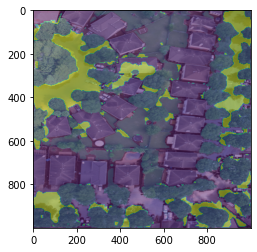

In [ ]:
test_preds_path  = '/content/drive/Shareddrives/FDL_Group_Project/models_UNET/test_preds/'

# Show simulated mask 
test_images = sorted(glob.glob(test_image_path+'*.jpg'))
test_mask = sorted(glob.glob(test_preds_path+'*.png'))

print(len(test_mask))

# Randomly select and image/mask pair from the training set
idx = np.random.choice(range(len(test_images)))
test_img = Image.open(test_images[idx])
test_msk = Image.open(test_mask[idx])

print('test_images[idx] :', test_images[idx])
print("Test_img :", test_img)

print('Image Size:',test_img.size)
print('Mask Size:',test_msk.size)

# Show the image
plt.imshow(test_img.resize((1000,1000)))
plt.imshow(test_msk.resize((1000,1000)), alpha=0.5)
plt.show()